# TITLE!!!!!!!!!!

## Introduction
There’s a widespread assumption in investing that more risk equals increased potential returns.Thus, the main goal for investors is to find the optimal weights for each asset and predict the most substantial possible return given a specific portfolio. In this project, our aim is to use different financial stock prices from Yahoo Finance to find best fitted time series forecasting Models for a single time step. The specific models we will employ are CNN, Simple RNN, LSTM and GRU that we've been exposed to during this class. 

Our project could be divided into three parts:
1. Using time series data and the WindowGenerator class, we could predict 1 step further and find the best fitted model by measuring and comparing the model’s performance.
2. Analyze the best investment portfolio via Monte-Carlo Simulation and choose the optimal asset allocation with the selected stock.
3. We will combine the results from part 1 and 2 and derive the optimal return in the 1 step further.

### Import Packages and Data Download
First, we import the required libraries and acquire the data from [Yahoo Finance](https://finance.yahoo.com/)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
from keras import layers as layers
import seaborn as sns
import datetime
from pandas_datareader import data as web

%matplotlib inline

We use `pandas_datareader` to import stock daily prices from finance yahoo with the date from 2015-01-01 until 2022-05-16, which is a total of 1856 days. In this project, we mainly focus on three financial stock prices: Apple Inc. (`aapl`), IBM (`ibm`) and Amazon.com, Inc. (`amzn`). For each stock, we obtained the following data:

- `High`: daily highest stock price
- `Low`: daily highest close price
- `Open`: daily open price
- `Close`: daily close price
- `Volume`: daily number of traded stock shares
- `Adj Close`: daily adjusted close price

We use `‘Adj Close’` of each stock for our analysis and visualize them in the following graphs.

In [17]:
start= datetime.datetime(2015,1,1)
end= datetime.datetime(2022,5,16)

aapl = web.DataReader('AAPL', 'yahoo', start, end)
ibm = web.DataReader('IBM', 'yahoo', start, end)
amzn = web.DataReader('AMZN', 'yahoo', start, end)

Text(0.5, 1.0, 'AMZN')

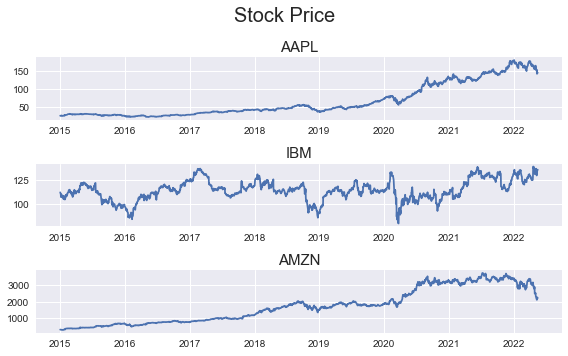

In [21]:
fig, axs = plt.subplots(3,1,sharey=False, tight_layout=True,figsize=(8, 5))
fig.suptitle('Stock Price', fontsize=20)
plt.style.use('seaborn')

axs[0].plot(aapl['Adj Close'])
axs[0].set_title('AAPL', size = 15)
axs[1].plot(ibm['Adj Close'])
axs[1].set_title('IBM', size = 15)
axs[2].plot(amzn['Adj Close'])
axs[2].set_title('AMZN', size = 15)

### Data Preperation
We define the return for each stock as the differences of logged prices of two consecutive trading days.

In [22]:
# Extract the adjusted closing price of each stock
df_aapl=pd.DataFrame(aapl["Adj Close"])
df_ibm=pd.DataFrame(ibm["Adj Close"])
df_amzn=pd.DataFrame(amzn["Adj Close"])

# Calculate Return
diff = lambda x: x.diff(1)
log_diff = lambda x: 100*np.log(x).diff(1)

df_aapl = df_aapl.transform({"Adj Close": log_diff}).dropna()
df_ibm = df_ibm.transform({"Adj Close": log_diff}).dropna()
df_amzn = df_amzn.transform({"Adj Close": log_diff}).dropna()

# Combine returns of each stock to a dataframe
stock_return=pd.concat([df_aapl,df_ibm,df_amzn],axis=1)
stock_return.describe()

,Adj Close,Adj Close,Adj Close
count,1855.000000,1855.000000,1855.000000
mean,0.095662,0.009995,0.106295
std,1.846950,1.569365,1.988347
min,-13.770814,-13.754767,-15.139797
25%,-0.698602,-0.648746,-0.793083
50%,0.089275,0.048878,0.121415
75%,1.018976,0.716238,1.070103
max,11.315746,10.706831,13.217792


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'AMZN Daily Returns Distribution'),
 Text(0.5, 0, 'Returns')]

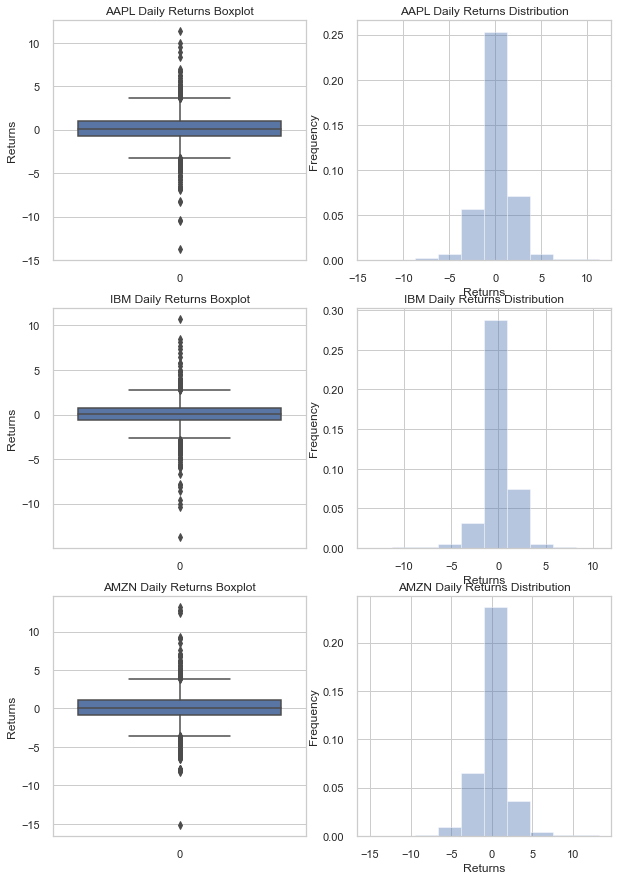

In [29]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(10,15))
sns.set(style="whitegrid", font_scale=1)

# AAPL Boxplot
image1 = sns.boxplot(data=df_aapl['Adj Close'], orient='v',ax=ax[0,0])
image1.set(ylabel='Returns', title='AAPL Daily Returns Boxplot')

# AAPL Distribution
image2 = sns.distplot(df_aapl['Adj Close'],kde=False,norm_hist=True,bins=10,ax=ax[0,1])
image2.set(ylabel='Frequency', title='AAPL Daily Returns Distribution',xlabel='Returns')

# IBM Boxplot
image3 = sns.boxplot(data=df_ibm['Adj Close'], orient='v',ax=ax[1,0])
image3.set(ylabel='Returns', title='IBM Daily Returns Boxplot')

# IBM Distribution
image4 = sns.distplot(df_ibm['Adj Close'],kde=False,norm_hist=True,bins=10,ax=ax[1,1])
image4.set(ylabel='Frequency', title='IBM Daily Returns Distribution',xlabel='Returns')

# AMZN Boxplot
image5 = sns.boxplot(data=df_amzn['Adj Close'], orient='v',ax=ax[2,0])
image5.set(ylabel='Returns', title='AMZN Daily Returns Boxplot')

# AMZN Distribution
image6 = sns.distplot(df_amzn['Adj Close'],kde=False,norm_hist=True,bins=10,ax=ax[2,1])
image6.set(ylabel='Frequency', title='AMZN Daily Returns Distribution',xlabel='Returns')

As we can see from the above data frame and graphs, the daily returns and volumes of each stock are centered around 0, suggesting mean-reversion of returns.

### Train-Test-Split
We use a (70%, 20%, 10%) split for the train, validation and test sets, and visualize them in the following graphs.

In [30]:
##############
#### AAPL ####
##############
n = df_aapl.shape[0]

# Training data
train_n = int(n*0.7)
train_df_aapl = df_aapl.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df_aapl = df_aapl.iloc[train_n:train_n+val_n, :]

# Testing data
test_df_aapl = df_aapl.iloc[train_n+val_n:, :]


##############
#### IBM #####
##############
n = df_ibm.shape[0]

# Training data
train_n = int(n*0.7)
train_df_ibm = df_ibm.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df_ibm = df_ibm.iloc[train_n:train_n+val_n, :]

# Testing data
test_df_ibm = df_ibm.iloc[train_n+val_n:, :]


##############
#### AMZN ####
##############
n = df_amzn.shape[0]

# Training data
train_n = int(n*0.7)
train_df_amzn = df_amzn.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df_amzn = df_amzn.iloc[train_n:train_n+val_n, :]

# Testing data
test_df_amzn = df_amzn.iloc[train_n+val_n:, :]

<AxesSubplot:xlabel='Date'>

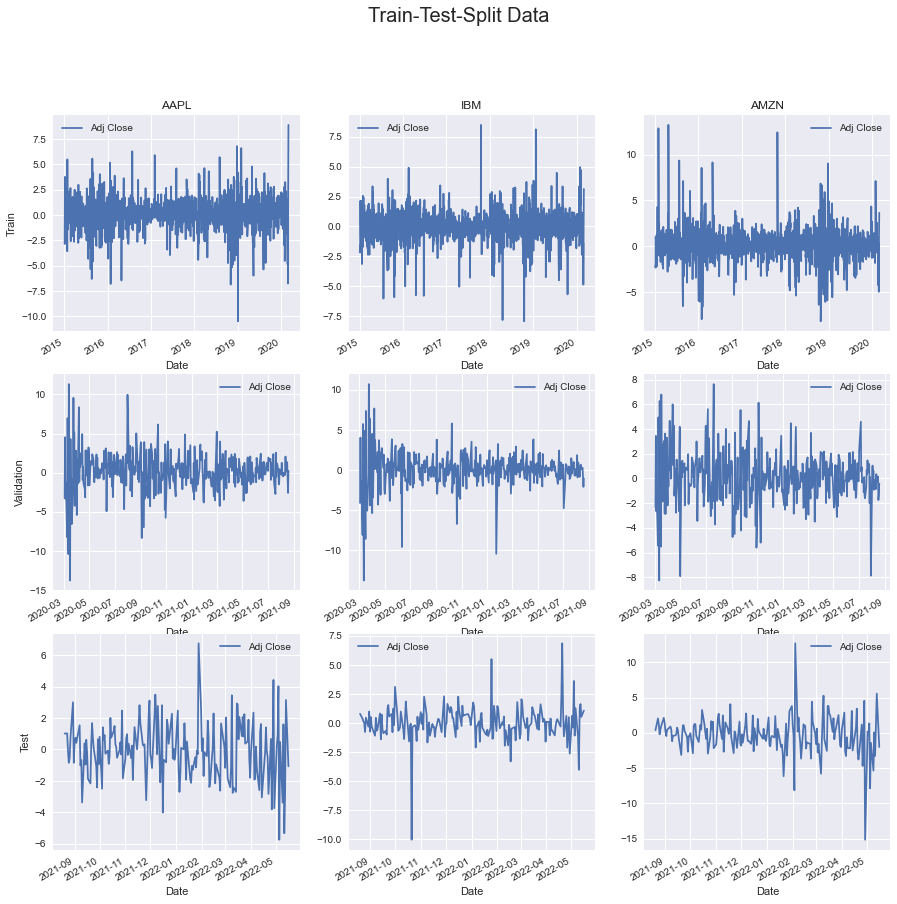

In [50]:
## Visualize train-test-split data for each stock
fig, ax = plt.subplots(ncols=3,nrows=3,figsize=(15,15))
fig.suptitle('Train-Test-Split Data', fontsize=20)
plt.style.use('seaborn')
#Train data
train_df_aapl.plot(y="Adj Close",ax=ax[0,0], title="AAPL",ylabel='Train')
train_df_ibm.plot(y="Adj Close",ax=ax[0,1], title="IBM")
train_df_amzn.plot(y="Adj Close",ax=ax[0,2], title="AMZN")
#Validation data
val_df_aapl.plot(y="Adj Close",ax=ax[1,0],ylabel='Validation')
val_df_ibm.plot(y="Adj Close",ax=ax[1,1])
val_df_amzn.plot(y="Adj Close",ax=ax[1,2])
#Test data
test_df_aapl.plot(y="Adj Close",ax=ax[2,0],ylabel='Test')
test_df_ibm.plot(y="Adj Close",ax=ax[2,1])
test_df_amzn.plot(y="Adj Close",ax=ax[2,2])

# Part 1: Return Prediction
In light by Lecture 16, we use different machine learning models (i.e. CNN, Simple RNN, LSTM, GRU) to predict future returns for each selected stocks. We select the most-fitted machine learning model for each stock based on their test and validation performances.

We use AAPL stock as an example to demonstrate our reasoning behind model selection.

In [54]:
class WindowGenerator():

    def __init__(
        self, input_width, label_width, shift,
        train_df, val_df, test_df,
        label_columns=None
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {
            name: i for i, name in enumerate(train_df.columns)
        }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join(
            [
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ], axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
    
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices, predictions[n, :, 0],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64
                )

            if n == 0:
                plt.legend()

        plt.xlabel('Months')


    def make_prediction(self, model):
        """ return the predicted return for tomorrow """
        inputs,  = self.example
        predictions = model(inputs)
        return predictions[len(inputs)-1, :, 0].numpy()[-1]


    def prediction_plot(self, model, plot_col='Adj Close'):
        """ plot only the last rolling window """
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        n = len(inputs)-1

        plt.ylabel(f'{plot_col}')
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)

        predictions = model(inputs)
        plt.scatter(
            self.label_indices, predictions[n, :, 0],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64
        )

        plt.xlabel('Months')
    

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=22,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result

        return result

## AAPL

In [55]:
INPUT_WIDTH = 22
LABEL_WIDTH = 1
SHIFT = 1

eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    train_df=train_df_aapl, val_df=val_df_aapl, test_df=test_df_aapl,
    shift=SHIFT, label_columns=["Adj Close"]
)

In [56]:
MAX_EPOCHS = 250

def compile_and_fit(model, window, patience=5):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.RMSprop(),
    )


    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

Baseline

In [57]:
class BaselineInflation(tf.keras.Model):
    def __init__(self, gamma, label_index=None):
        super().__init__()
        self.gamma = gamma
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            x = self.gamma*inputs + (1-self.gamma)*0
        else:
            x = self.gamma*inputs[:, :, self.label_index] + (1-self.gamma)*0

        return x[:, :, tf.newaxis]

In [58]:
baseline_aapl = BaselineInflation(gamma=0.9, label_index=eval_window.column_indices["Adj Close"])
baseline_aapl.compile(loss=tf.losses.MeanSquaredError())

val_performance_aapl = {}
performance_aapl = {}

val_performance_aapl['Baseline'] = baseline_aapl.evaluate(eval_window.val)
performance_aapl['Baseline'] = baseline_aapl.evaluate(eval_window.test, verbose=0)

16/16 [==============================] - 0s 951us/step - loss: 8.7388


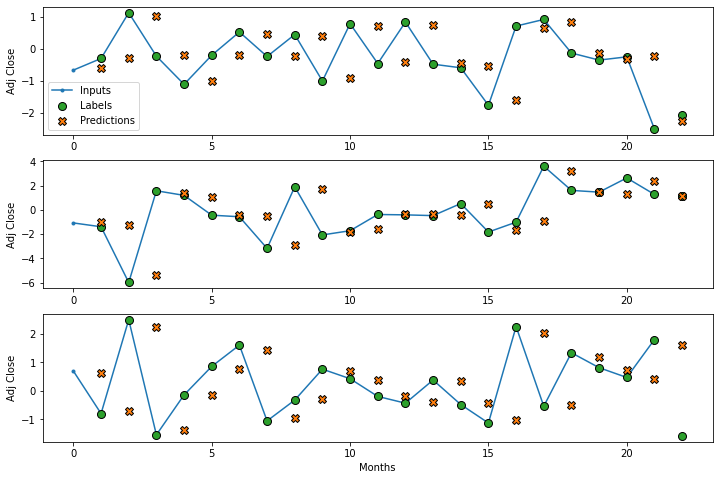

In [59]:
# wide_window_baseline = WindowGenerator(
#     input_width=INPUT_WIDTH, label_width=INPUT_WIDTH,
#     train_df=train_df_aapl, val_df=val_df_aapl, test_df=test_df_aapl,
#     shift=SHIFT, label_columns=["Adj Close"]
# )

# wide_window_baseline.plot(baseline_aapl, max_subplots=3)

CNN

In [60]:
CONV_WIDTH = 22

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df_aapl, val_df=val_df_aapl, test_df=test_df_aapl,
    label_width=1,
    shift=1
)

conv_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters=8, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model_aapl, conv_window)

val_performance_aapl['Conv1D'] = conv_model_aapl.evaluate(eval_window.val)
performance_aapl['Conv1D'] = conv_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 1s 3ms/step - loss: 2.7310 - val_loss: 4.3489
Epoch 2/250
58/58 [==============================] - 0s 3ms/step - loss: 2.6284 - val_loss: 4.2860
Epoch 3/250
58/58 [==============================] - 0s 3ms/step - loss: 2.5758 - val_loss: 4.2615
Epoch 4/250
58/58 [==============================] - 0s 3ms/step - loss: 2.5398 - val_loss: 4.2619
Epoch 5/250
58/58 [==============================] - 0s 3ms/step - loss: 2.5105 - val_loss: 4.2741
Epoch 6/250
58/58 [==============================] - 0s 3ms/step - loss: 2.4870 - val_loss: 4.2939
Epoch 7/250
58/58 [==============================] - 0s 2ms/step - loss: 2.4625 - val_loss: 4.3131
Epoch 8/250
16/16 [==============================] - 0s 1ms/step - loss: 4.3411


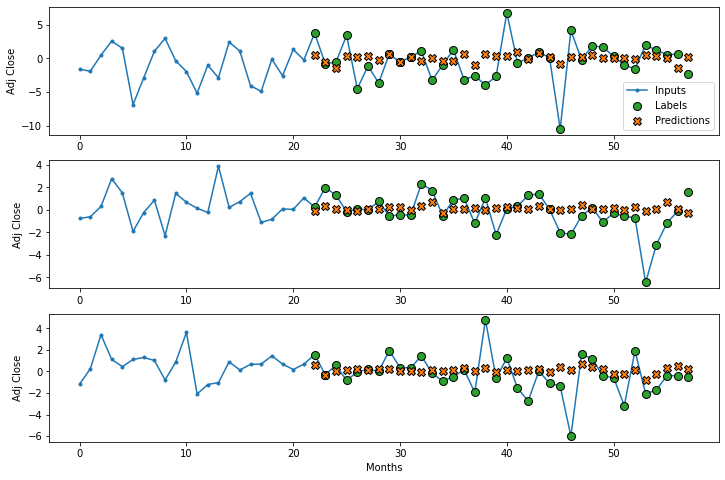

In [61]:
# wide_window_conv = WindowGenerator(
#     input_width=36 + (CONV_WIDTH - 1),
#     label_width=36,
#     train_df=train_df_aapl, val_df=val_df_aapl, test_df=test_df_aapl,
#     shift=SHIFT
# )

# wide_window_conv.plot(conv_model_aapl, max_subplots=3)

RNN

In [62]:
srnn_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model_aapl, eval_window)

val_performance_aapl['SimpleRNN'] = srnn_model_aapl.evaluate(eval_window.val)
performance_aapl['SimpleRNN'] = srnn_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 1s 6ms/step - loss: 3.2801 - val_loss: 5.3771
Epoch 2/250
58/58 [==============================] - 0s 5ms/step - loss: 2.8594 - val_loss: 4.8173
Epoch 3/250
58/58 [==============================] - 0s 4ms/step - loss: 2.6795 - val_loss: 4.5589
Epoch 4/250
58/58 [==============================] - 0s 5ms/step - loss: 2.6064 - val_loss: 4.4403
Epoch 5/250
58/58 [==============================] - 0s 5ms/step - loss: 2.5766 - val_loss: 4.3869
Epoch 6/250
58/58 [==============================] - 0s 5ms/step - loss: 2.5651 - val_loss: 4.3659
Epoch 7/250
58/58 [==============================] - 0s 5ms/step - loss: 2.5539 - val_loss: 4.3577
Epoch 8/250
58/58 [==============================] - 0s 4ms/step - loss: 2.5492 - val_loss: 4.3475
Epoch 9/250
58/58 [==============================] - 0s 4ms/step - loss: 2.5454 - val_loss: 4.3360
Epoch 10/250
58/58 [==============================] - 0s 4ms/step - loss: 2.5413 - val_loss: 4.3380
Epoch 11/

LSTM

In [63]:
lstm_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(32, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('linear')
    ]
)

compile_and_fit(lstm_model_aapl, eval_window)

val_performance_aapl['LSTM'] = lstm_model_aapl.evaluate(eval_window.val)
performance_aapl['LSTM'] = lstm_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 2s 9ms/step - loss: 2.5638 - val_loss: 4.3428
Epoch 2/250
58/58 [==============================] - 1s 8ms/step - loss: 2.5474 - val_loss: 4.3059
Epoch 3/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5469 - val_loss: 4.3320
Epoch 4/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5453 - val_loss: 4.3057
Epoch 5/250
58/58 [==============================] - 0s 6ms/step - loss: 2.5393 - val_loss: 4.3926
Epoch 6/250
58/58 [==============================] - 0s 8ms/step - loss: 2.5441 - val_loss: 4.3448
Epoch 7/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5400 - val_loss: 4.3396
Epoch 8/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5338 - val_loss: 4.4169
Epoch 9/250
16/16 [==============================] - 0s 2ms/step - loss: 4.3962


GRU

In [64]:
gru_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model_aapl, eval_window)

val_performance_aapl['GRU'] = gru_model_aapl.evaluate(eval_window.val)
performance_aapl['GRU'] = gru_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 2s 10ms/step - loss: 2.5526 - val_loss: 4.3377
Epoch 2/250
58/58 [==============================] - 0s 8ms/step - loss: 2.5344 - val_loss: 4.3120
Epoch 3/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5351 - val_loss: 4.3085
Epoch 4/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5334 - val_loss: 4.3073
Epoch 5/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5362 - val_loss: 4.3131
Epoch 6/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5310 - val_loss: 4.3070
Epoch 7/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5325 - val_loss: 4.3153
Epoch 8/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5307 - val_loss: 4.3093
Epoch 9/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5301 - val_loss: 4.3113
Epoch 10/250
58/58 [==============================] - 0s 8ms/step - loss: 2.5317 - val_loss: 4.3175
Epoch 11

In [65]:
performance_aapl

{'Baseline': 6.074245929718018,
 'Conv1D': 3.417404890060425,
 'SimpleRNN': 3.5853676795959473,
 'LSTM': 3.5592968463897705,
 'GRU': 3.5687732696533203}

In [66]:
val_performance_aapl

{'Baseline': 8.738819122314453,
 'Conv1D': 4.341091156005859,
 'SimpleRNN': 4.333291530609131,
 'LSTM': 4.396188735961914,
 'GRU': 4.322207450866699}

## IBM

In [68]:
eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    train_df=train_df_ibm, val_df=val_df_ibm, test_df=test_df_ibm,
    shift=SHIFT, label_columns=["Adj Close"]
)


####################
##### Baseline #####
####################
baseline_ibm = BaselineInflation(gamma=0.9, label_index=eval_window.column_indices["Adj Close"])
baseline_ibm.compile(loss=tf.losses.MeanSquaredError())

val_performance_ibm = {}
performance_ibm = {}

val_performance_ibm['Baseline'] = baseline_ibm.evaluate(eval_window.val)
performance_ibm['Baseline'] = baseline_ibm.evaluate(eval_window.test, verbose=0)




####################
####### CNN ########
####################
CONV_WIDTH = 22

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df_ibm, val_df=val_df_ibm, test_df=test_df_ibm,
    label_width=1,
    shift=1
)

conv_model_ibm = tf.keras.Sequential(
    [tf.keras.layers.Conv1D(filters=8, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model_ibm, conv_window)

val_performance_ibm['Conv1D'] = conv_model_ibm.evaluate(eval_window.val)
performance_ibm['Conv1D'] = conv_model_ibm.evaluate(eval_window.test, verbose=0)



####################
####### RNN ########
####################
srnn_model_ibm = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model_ibm, eval_window)

val_performance_ibm['SimpleRNN'] = srnn_model_ibm.evaluate(eval_window.val)
performance_ibm['SimpleRNN'] = srnn_model_ibm.evaluate(eval_window.test, verbose=0)



####################
####### LSTM #######
####################
lstm_model_ibm = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(32, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('linear')
    ]
)

compile_and_fit(lstm_model_ibm, eval_window)

val_performance_ibm['LSTM'] = lstm_model_ibm.evaluate(eval_window.val)
performance_ibm['LSTM'] = lstm_model_ibm.evaluate(eval_window.test, verbose=0)



####################
####### GRU ########
####################
gru_model_ibm = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model_ibm, eval_window)

val_performance_ibm['GRU'] = gru_model_ibm.evaluate(eval_window.val)
performance_ibm['GRU'] = gru_model_ibm.evaluate(eval_window.test, verbose=0)


16/16 [==============================] - 0s 811us/step - loss: 6.7530
Epoch 1/250
58/58 [==============================] - 1s 4ms/step - loss: 1.8149 - val_loss: 3.3005
Epoch 2/250
58/58 [==============================] - 0s 2ms/step - loss: 1.7519 - val_loss: 3.2484
Epoch 3/250
58/58 [==============================] - 0s 2ms/step - loss: 1.7258 - val_loss: 3.2371
Epoch 4/250
58/58 [==============================] - 0s 3ms/step - loss: 1.7093 - val_loss: 3.2319
Epoch 5/250
58/58 [==============================] - 0s 2ms/step - loss: 1.6979 - val_loss: 3.2267
Epoch 6/250
58/58 [==============================] - 0s 2ms/step - loss: 1.6878 - val_loss: 3.2317
Epoch 7/250
58/58 [==============================] - 0s 4ms/step - loss: 1.6788 - val_loss: 3.2349
Epoch 8/250
58/58 [==============================] - 0s 2ms/step - loss: 1.6702 - val_loss: 3.2488
Epoch 9/250
58/58 [==============================] - 0s 2ms/step - loss: 1.6629 - val_loss: 3.2587
Epoch 10/250
16/16 [===================

In [69]:
performance_ibm

{'Baseline': 4.177738666534424,
 'Conv1D': 2.546647548675537,
 'SimpleRNN': 2.3851754665374756,
 'LSTM': 2.395151138305664,
 'GRU': 2.416637420654297}

In [70]:
val_performance_ibm

{'Baseline': 6.753039360046387,
 'Conv1D': 3.2650511264801025,
 'SimpleRNN': 3.1701695919036865,
 'LSTM': 3.18379282951355,
 'GRU': 3.154911756515503}

## AMZN

In [72]:
eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    train_df=train_df_amzn, val_df=val_df_amzn, test_df=test_df_amzn,
    shift=SHIFT, label_columns=["Adj Close"],
)

####################
##### Baseline #####
####################
baseline_amzn = BaselineInflation(gamma=0.9, label_index=eval_window.column_indices["Adj Close"])
baseline_amzn.compile(loss=tf.losses.MeanSquaredError())

val_performance_amzn = {}
performance_amzn = {}

val_performance_amzn['Baseline'] = baseline_amzn.evaluate(eval_window.val)
performance_amzn['Baseline'] = baseline_amzn.evaluate(eval_window.test, verbose=0)



####################
####### CNN ########
####################
CONV_WIDTH = 22

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df_amzn, val_df=val_df_amzn, test_df=test_df_amzn,
    label_width=1,
    shift=1
)

conv_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters=8, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model_amzn, conv_window)

val_performance_amzn['Conv1D'] = conv_model_amzn.evaluate(eval_window.val)
performance_amzn['Conv1D'] = conv_model_amzn.evaluate(eval_window.test, verbose=0)


####################
####### SRNN #######
####################
srnn_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model_amzn, eval_window)

val_performance_amzn['SimpleRNN'] = srnn_model_amzn.evaluate(eval_window.val)
performance_amzn['SimpleRNN'] = srnn_model_amzn.evaluate(eval_window.test, verbose=0)



####################
####### LSTM #######
####################
lstm_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(32, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('linear')
    ]
)

compile_and_fit(lstm_model_amzn, eval_window)

val_performance_amzn['LSTM'] = lstm_model_amzn.evaluate(eval_window.val)
performance_amzn['LSTM'] = lstm_model_amzn.evaluate(eval_window.test, verbose=0)



####################
####### GRU ########
####################
gru_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model_amzn, eval_window)

val_performance_amzn['GRU'] = gru_model_amzn.evaluate(eval_window.val)
performance_amzn['GRU'] = gru_model_amzn.evaluate(eval_window.test, verbose=0)

16/16 [==============================] - 0s 775us/step - loss: 7.3403
Epoch 1/250
58/58 [==============================] - 1s 3ms/step - loss: 3.2597 - val_loss: 3.9926
Epoch 2/250
58/58 [==============================] - 0s 2ms/step - loss: 3.2166 - val_loss: 3.9863
Epoch 3/250
58/58 [==============================] - 0s 2ms/step - loss: 3.1862 - val_loss: 3.9825
Epoch 4/250
58/58 [==============================] - 0s 2ms/step - loss: 3.1610 - val_loss: 3.9889
Epoch 5/250
58/58 [==============================] - 0s 2ms/step - loss: 3.1433 - val_loss: 3.9964
Epoch 6/250
58/58 [==============================] - 0s 2ms/step - loss: 3.1250 - val_loss: 4.0086
Epoch 7/250
58/58 [==============================] - 0s 2ms/step - loss: 3.1090 - val_loss: 4.0175
Epoch 8/250
16/16 [==============================] - 0s 846us/step - loss: 4.0248
Epoch 1/250
58/58 [==============================] - 1s 5ms/step - loss: 6.1329 - val_loss: 5.5415
Epoch 2/250
58/58 [==============================] - 0s 

In [73]:
performance_amzn

{'Baseline': 12.408007621765137,
 'Conv1D': 7.85417366027832,
 'SimpleRNN': 7.7083210945129395,
 'LSTM': 7.849979400634766,
 'GRU': 7.733346462249756}

In [74]:
val_performance_amzn

{'Baseline': 7.340343952178955,
 'Conv1D': 4.02480411529541,
 'SimpleRNN': 3.9612536430358887,
 'LSTM': 3.8882253170013428,
 'GRU': 3.888244867324829}

## validation performance df

In [75]:
val_aapl = pd.DataFrame.from_dict(val_performance_aapl, orient = 'index', columns=["aapl_val"])
val_ibm = pd.DataFrame.from_dict(val_performance_ibm, orient = 'index', columns=["ibm_val"])
val_amzn = pd.DataFrame.from_dict(val_performance_amzn, orient = 'index', columns=["amzn_val"])
val_df = pd.concat([val_aapl, val_ibm, val_amzn],axis=1)
val_df

,aapl_val,ibm_val,amzn_val
Baseline,8.738819,6.753039,7.340344
Conv1D,4.341091,3.265051,4.024804
SimpleRNN,4.333292,3.170170,3.961254
LSTM,4.396189,3.183793,3.888225
GRU,4.322207,3.154912,3.888245


## test performance df

In [76]:
p_aapl = pd.DataFrame.from_dict(performance_aapl, orient = 'index', columns=["aapl_test"])
p_ibm = pd.DataFrame.from_dict(performance_ibm, orient = 'index', columns=["ibm_test"])
p_amzn = pd.DataFrame.from_dict(performance_amzn, orient = 'index', columns=["amzn_test"])
p_df = pd.concat([p_aapl, p_ibm, p_amzn],axis=1)
p_df

,aapl_test,ibm_test,amzn_test
Baseline,6.074246,4.177739,12.408008
Conv1D,3.417405,2.546648,7.854174
SimpleRNN,3.585368,2.385175,7.708321
LSTM,3.559297,2.395151,7.849979
GRU,3.568773,2.416637,7.733346


## Plot

<function matplotlib.pyplot.show(close=None, block=None)>

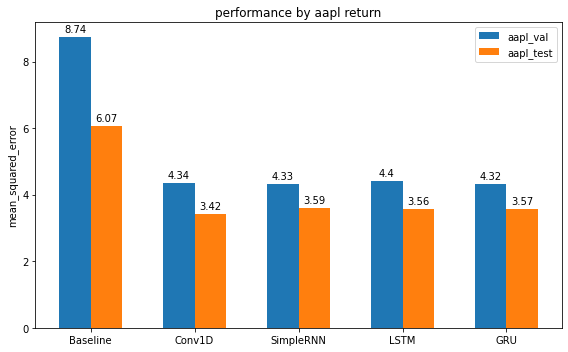

In [77]:
a=[]
for i in val_df['aapl_val'].to_list():
    a.append(round(i, 2))

b=[]
for i in p_df['aapl_test'].to_list():
    b.append(round(i, 2))

labels = ['Baseline','Conv1D','SimpleRNN','LSTM','GRU']
x = np.arange(len(performance_aapl))
width = 0.3

fig,ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, a, width, label='aapl_val')
rects2 = ax.bar(x + width/2, b,width, label='aapl_test')

ax.set_ylabel('mean_squared_error')
ax.set_title('performance by aapl return')
plt.xticks(ticks=x, labels=labels,)
_ = plt.legend()
ax.legend()

ax.bar_label(rects1,padding=3)
ax.bar_label(rects2,padding=3)

fig.tight_layout()

plt.show

> **GRU model** has overall a better performance in AAPL return.

<function matplotlib.pyplot.show(close=None, block=None)>

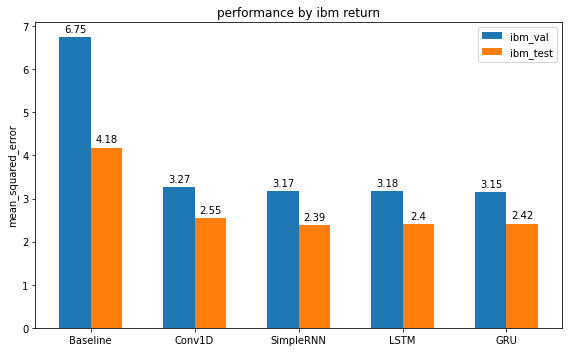

In [78]:
a=[]
for i in val_df['ibm_val'].to_list():
    a.append(round(i, 2))

b=[]
for i in p_df['ibm_test'].to_list():
    b.append(round(i, 2))

labels = ['Baseline','Conv1D','SimpleRNN','LSTM','GRU']
x = np.arange(len(performance_ibm))
width = 0.3

fig,ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, a, width, label='ibm_val')
rects2 = ax.bar(x + width/2, b,width, label='ibm_test')

ax.set_ylabel('mean_squared_error')
ax.set_title('performance by ibm return')
plt.xticks(ticks=x, labels=labels,)
_ = plt.legend()
ax.legend()

ax.bar_label(rects1,padding=3)
ax.bar_label(rects2,padding=3)

fig.tight_layout()

plt.show

> **Simple RNN model** has a better performance in IBM return

<function matplotlib.pyplot.show(close=None, block=None)>

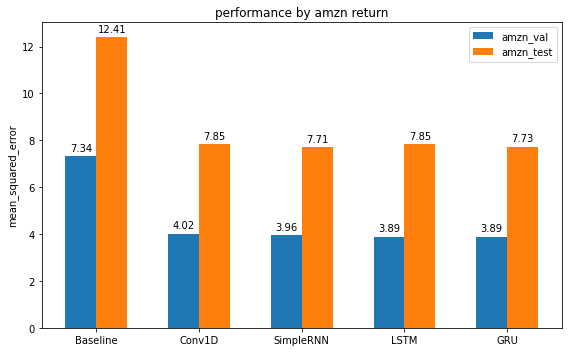

In [79]:
a=[]
for i in val_df['amzn_val'].to_list():
    a.append(round(i, 2))

b=[]
for i in p_df['amzn_test'].to_list():
    b.append(round(i, 2))

labels = ['Baseline','Conv1D','SimpleRNN','LSTM','GRU']
x = np.arange(len(performance_amzn))
width = 0.3

fig,ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, a, width, label='amzn_val')
rects2 = ax.bar(x + width/2, b,width, label='amzn_test')

ax.set_ylabel('mean_squared_error')
ax.set_title('performance by amzn return')
plt.xticks(ticks=x, labels=labels,)
_ = plt.legend()
ax.legend()

ax.bar_label(rects1,padding=3)
ax.bar_label(rects2,padding=3)

fig.tight_layout()

plt.show

> **LSTM model** is a better fit for AMZN stock return.

## Prediction

Using the selected models from the section above, we predict the stock returns for the next day. The selected models are:
- GRU model for AAPL
- Simple RNN model for IBM
- LSTM model for AMZN

We here define a function to extract the last window containing 22 days as the test set used for prediction.

In [80]:
def preprocess_testdat(data, test_df, window_size=22):    
    raw = data['Adj Close'][len(data) - len(test_df) - window_size:].values # locate the last window period
    raw = raw.reshape(-1,1)

    
    X_test = []
    for i in range(window_size, raw.shape[0]+1):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
    return X_test

### AAPL Prediction

In [81]:
test_aapl = preprocess_testdat(df_aapl, test_df = test_df_aapl)
predict_gru_aapl = gru_model_aapl.predict(test_aapl)[-1][0]
predict_gru_aapl

0.20327926

### IBM Prediction

In [82]:
test_ibm = preprocess_testdat(df_ibm, test_df = test_df_ibm)
predict_gru_ibm = srnn_model_ibm.predict(test_ibm)[-1][0]
predict_gru_ibm

0.2294198

### AMZN Prediction

In [83]:
test_amzn = preprocess_testdat(df_amzn, test_df = test_df_amzn)
predict_gru_amzn = lstm_model_amzn.predict(test_amzn)[-1][0]
predict_gru_amzn

0.4612243

> Based on our prediction using the most fitted models, returns of selected stocks on 2022-05-17 should be:
- $0.055961348 for AAPL
- $0.09477261 for IBM
- $0.20754439 for AMZN